In [1]:
using PhyloTrees
using BioSequences
using Plots
using Distributions
using SubstitutionModels

INFO: Recompiling stale cache file C:\Users\bjorn\.julia\lib\v0.6\PhyloTrees.ji for module PhyloTrees.


In [2]:
f = open("dna.txt");
s = readlines(f)
close(f)


In [3]:
d = [split(x) for x in s if x != ""]
dna = Dict(x[1] => convert(DNASequence, x[2]) for x in d)

Dict{SubString{String},BioSequences.BioSequence{BioSequences.DNAAlphabet{4}}} with 11 entries:
  "U09126"   => GAGGGGATACAGAGGAATTGGAAACAATGGTGGATATGGGGCATC
  "U067158"  => AGGGGGACACTGAGGAATTATCAACAATGGTGGATATGGGGCGTC
  "L20571"   => AAAGTAATGAAGAAGAACAACAGGAAGTCATGGAGCTTATACATA
  "U27399"   => AGGGAGATGAGGAGGAATTGTCAGCATTTGTGGGGATGGGGCACC
  "AF025763" => AAGGGGATCAGGAAGAATTGTCAGCACTTGTGGAGATGGGGCATG
  "U43386"   => AGGGAGATGCAGAGGAATTATCAGCATTTATGGAAATGGGGCATC
  "L02317"   => AAGGAGATCAGGAAGAATTATCAGCACTTGTGGAGATGGGGCACC
  "U08443"   => AAGGAGATGAGGAAGCATTGTCAGCACTTATGGAGAGGGGGCACC
  "AF042106" => AAGGGGATCAGGAAGAATTATCGGCACTTGTGGACATGGGGCACC
  "U27445"   => AAGGGGATACGGACGAATTGGCAACACTTCTGGAGATGGGGAACT
  "U09127"   => ATGGGGATAGAGAGGAATTATCCTTGCTGGTGGACATGGGGGATT

In [5]:
function treerand(n::Int64 = 5, d = LogNormal(1.0, 1.0))
    tree = Tree()
    addnode!(tree)

    for i in 1:n
        t = rand(d, 2)
        branch!(tree, i, t[1])
        branch!(tree, i, t[2])
    end
    return(tree)
end

treerand (generic function with 3 methods)

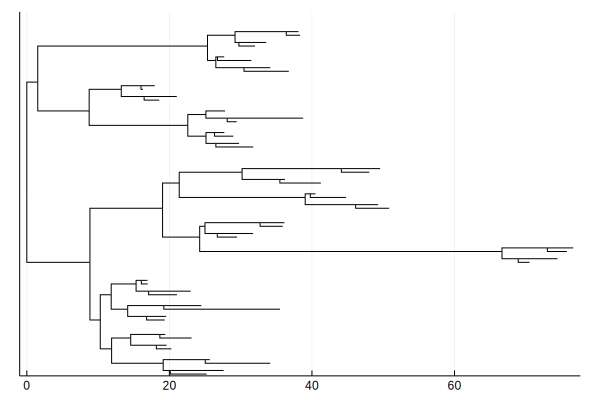

  0.000200 seconds (727 allocations: 52.484 KiB)


In [588]:
@time tree = treerand(50)
plot(tree)

LoadError: [91mSource node does not exist[39m

In [363]:
tree = Tree()

# See Yang 2014 pp. 105. Fig. 4.2

addnodes!(tree, 9)

addbranch!(tree, 1, 2, 0.1)
addbranch!(tree, 1, 3, 0.1)

addbranch!(tree, 2, 4, 0.1)
addbranch!(tree, 2, 5, 0.2)

addbranch!(tree, 4, 6, 0.2)
addbranch!(tree, 4, 7, 0.2)

addbranch!(tree, 3, 8, 0.2)

addbranch!(tree, 3, 9, 0.2)

Phylogenetic tree with 9 nodes and 8 branches

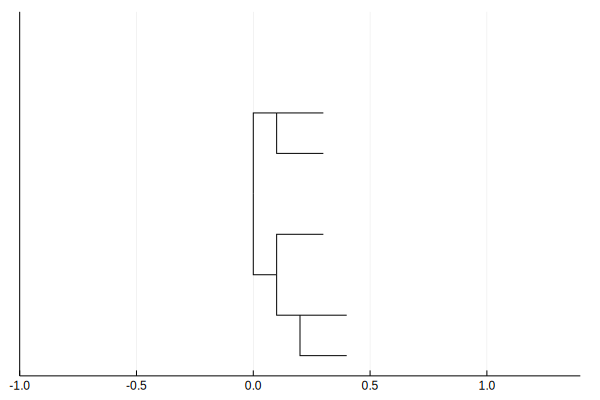

In [364]:
plot(tree)

In [365]:
visit_order = postorder(tree);

In [366]:
#mod = JC69()
mod = K80(2.0)

Kimura 1980 model (relative rate form)
κ = 2.0

In [409]:
nucleotides = [DNA_A, DNA_C, DNA_G ,DNA_T]

function dna_to_vec(DNA::BioSymbols.DNA)
    if DNA == DNA_A
        res = [1, 0, 0, 0]
    elseif DNA == DNA_C
        res = [0, 1, 0, 0]
    elseif DNA == DNA_G
        res = [0, 0, 1, 0]
    elseif DNA == DNA_T
        res = [0, 0, 0, 1]
    else
        error()
    end
    
    return(res)
end



dna_to_vec (generic function with 1 method)

In [410]:
leaves = Dict(i => tree.nodes[i] for i in visit_order if isleaf(tree, i));

In [411]:
node_data = Dict{Int64, BioSymbols.DNA}(7 => DNA_T, 6 => DNA_C, 5 => DNA_A, 9 => DNA_C, 8 => DNA_C)

n = length(values(node_data))
base_freq = Dict(nucleotide => sum(nucleotide == x for x in values(node_data)) / n for nucleotide in nucleotides)


Dict{BioSymbols.DNA,Float64} with 4 entries:
  DNA_T => 0.2
  DNA_C => 0.6
  DNA_A => 0.2
  DNA_G => 0.0

In [ ]:
visit_order = postorder(tree)

In [675]:
#bl = [0.2, 0.2, 0.1, 0.1, 0.2, 0.2, 0.2, 0.1]

function logLik(tree, bl, node_data, base_freq, mod)
    #for (idx, (k, v)) in enumerate(tree.branches)
    #    setlength!(tree, k, bl[idx])
    #end
        
    visit_order = postorder(tree)
    π₀ = collect(values(base_freq)) # The equilibrium frequency at the root
    
    L = Dict{Int64, Array{Float64}}()  ## Lᵢ is the vector conditional proability.

    #food = Dict(7 => 1, 6 => 2, 5 => 3, 9 => 4, 8 => 5, 3 => 8, 1 => 0, 2 => 6, 4 => 6, )

    for i in visit_order
        if isleaf(tree, i)
            L[i] = dna_to_vec(node_data[i])
        else
            branches = tree.nodes[i].out
            res = zeros(4, length(branches))
            
            for (idx, j) in enumerate(branches)
                branch_length = tree.branches[j].length
                #branch_length = bl[j]
                child_node = tree.branches[j].target
                
                res[:,idx] = P(mod, branch_length) * L[child_node]
            end
            
            L[i] = prod(res, 2)      
        end
    end
    root = findroots(tree)[1]
    logL = log(sum(L[root] .* π₀))
    
    return(logL)
end

logLik (generic function with 3 methods)

In [614]:
s = open("primates.dna") do file
    read(file, String)
end
s = split(s, "\n")
s = s[2:end-1];

In [616]:
species = [strip(x[1:10]) for x in  s[1:14]]

14-element Array{SubString{String},1}:
 "Mouse"     
 "Bovine"    
 "Lemur"     
 "Tarsier"   
 "Squir Monk"
 "Jpn Macaq" 
 "Rhesus Mac"
 "Crab-E.Mac"
 "BarbMacaq" 
 "Gibbon"    
 "Orang"     
 "Gorilla"   
 "Chimp"     
 "Human"     

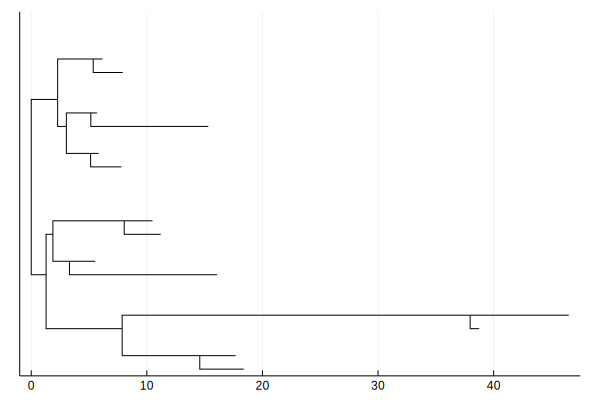

In [668]:
tree = treerand(13)
plot(tree)

In [662]:
data = [s[i:i+13] for i in [1, 16, 31, 46]]

dna = Dict()
for i in 1:14
    m = join([x[i] for x in data])
    
    species = strip(m[1:10])
    
    sequence = replace(m[11:end], " ", "")
    dna[species] = convert(BioSequence{DNAAlphabet{4}}, sequence)
end

In [673]:
node_data = Dict(node => dna[5] for (node, dna) in zip(findleaves(tree), values(dna)));

In [687]:
@time logLik(tree, [1,2,3], node_data, base_freq, mod)

-19.41030856794757

  0.000393 seconds (735 allocations: 143.172 KiB)


In [547]:
function foo(bl)
    res = logLik(tree, bl, node_data, base_freq)
    
    return(res)
end
    

foo (generic function with 2 methods)

In [533]:
g = bl -> ForwardDiff.gradient(foo, bl);

In [584]:
using Convex, SCS
using Clp, JuMP

INFO: Precompiling module JuMP.


In [585]:
m = Model(solver = ClpSolver())

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is ClpMathProg

In [580]:
bl = [0.2, 0.2, 0.1, 0.1, 0.2, 0.2, 0.2, 0.1]
#bl = reshape(bl, 8, 1)

x = Variable(8, :Float64)
problem = Convex.maximize(logLik(tree, x, node_data, base_freq, mod), [x >= 0])

LoadError: [91mMethodError: no method matching P_generic(::SubstitutionModels.K80rel, ::Convex.IndexAtom)[0m
Closest candidates are:
  P_generic(::SubstitutionModels.NucleicAcidSubstitutionModel, [91m::Float64[39m) at C:\Users\bjorn\.julia\v0.6\SubstitutionModels\src\nucleic_acid/nucleic_acid.jl:48
  P_generic(::SubstitutionModels.NucleicAcidSubstitutionModel, [91m::Array{Float64,N} where N[39m) at C:\Users\bjorn\.julia\v0.6\SubstitutionModels\src\nucleic_acid/nucleic_acid.jl:56[39m

In [540]:
bl = [0.2, 0.2, 0.1, 0.1, 0.2, 0.2, 0.2, 0.1]
for i in 1:100
    
    bl = bl .- 0.01*g(bl)
    println(bl)
end

LoadError: DomainError:
sqrt will only return a complex result if called with a complex argument. Try sqrt(complex(x)).

[0.190199, 0.190199, 0.0900498, 0.0900498, 0.190199, 0.190199, 0.190199, 0.0900498]
[0.18038, 0.18038, 0.0800903, 0.0800903, 0.18038, 0.18038, 0.18038, 0.0800903]
[0.170542, 0.170542, 0.0701223, 0.0701223, 0.170542, 0.170542, 0.170542, 0.0701223]
[0.160687, 0.160687, 0.0601469, 0.0601469, 0.160687, 0.160687, 0.160687, 0.0601469]
[0.150816, 0.150816, 0.0501649, 0.0501649, 0.150816, 0.150816, 0.150816, 0.0501649]
[0.140929, 0.140929, 0.0401775, 0.0401775, 0.140929, 0.140929, 0.140929, 0.0401775]
[0.131028, 0.131028, 0.0301856, 0.0301856, 0.131028, 0.131028, 0.131028, 0.0301856]
[0.121114, 0.121114, 0.0201901, 0.0201901, 0.121114, 0.121114, 0.121114, 0.0201901]
[0.111187, 0.111187, 0.0101922, 0.0101922, 0.111187, 0.111187, 0.111187, 0.0101922]
[0.101249, 0.101249, 0.000192682, 0.000192682, 0.101249, 0.101249, 0.101249, 0.000192682]
[0.0913003, 0.0913003, -0.00980732, -0.00980732, 0.0913003, 0.0913003, 0.0913003, -0.00980732]


In [538]:
foo(bl)

LoadError: DomainError:

In [539]:
bl

8-element Array{Float64,1}:
  3.59457e9
  3.59457e9
 -1.66668e8
 -1.66668e8
  3.59457e9
  3.59457e9
  3.59457e9
 -1.66668e8

In [530]:
#changelength!(tree2, 2, 5.0)
tree2.branches[2].length = 0.2

LoadError: [91mtype Branch is immutable[39m

In [519]:
tree2 = tree

for (idx, (k, v)) in enumerate(tree2.branches)
    setlength!(tree2, k, bl[idx])
end

plot(tree2)

LoadError: [91mtype is immutable[39m

In [447]:
@time logLik(tree, node_data, base_freq)

-6.793810057551627

  0.000196 seconds (259 allocations: 39.906 KiB)


In [422]:
sum(L[1] .* X₀)
tree.branches[1].length

0.0011206907333674839

In [456]:
using ForwardDiff

INFO: Recompiling stale cache file C:\Users\bjorn\.julia\lib\v0.6\DiffResults.ji for module DiffResults.
INFO: Recompiling stale cache file C:\Users\bjorn\.julia\lib\v0.6\ForwardDiff.ji for module ForwardDiff.


0.1

In [459]:
foo(x::Vector) = sum(sin, x) + prod(tan, x) * sum(sqrt, x);

In [465]:
g = x -> ForwardDiff.gradient(foo, x);

In [467]:
x = rand(5)

5-element Array{Float64,1}:
 0.0444268
 0.260791 
 0.718988 
 0.891581 
 0.734389 

In [471]:
@time g(x)

5-element Array{Float64,1}:
 1.90873 
 1.13467 
 0.838297
 0.714412
 0.827706

  0.000103 seconds (8 allocations: 912 bytes)


In [473]:
@time foo(x)

2.448220457152205

  0.000005 seconds (5 allocations: 176 bytes)


8-element Array{Float64,1}:
 0.2
 0.2
 0.1
 0.1
 0.2
 0.2
 0.2
 0.1

In [ ]:
using ProgressMeter